# Title
The title of the notebook should be coherent with file name. Namely, file name should be:    
*`<author's initials>-<title>-<date(if applicable)>`.ipynb*    
For example:    
*ra-job-level-exploration-2020-06-01.ipynb*

## Purpose
State the purpose of the notebook.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results and aftermath
Describe and comment the most important results and actionables.



# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import seaborn as sns

import pydash as _
import datetime
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import json
import datetime
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from bayes_opt import BayesianOptimization
import re
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, auc, roc_curve

## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths

# Import local libraries

autostats_lib = os.environ['AUTOSTATS']
if autostats_lib not in sys.path:
    sys.path.append(autostats_lib)
from scorecard.scorecard import Scorecard
from scorecard.binning_builder import BinningBuilder

## Common Functions

In [3]:
def display_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

def quick_pivot(data):
    data = data.fillna(0)
    if 'GOOD' in data.columns:
        for col in data.columns:
            if "BAD" in col:
                bad_col = col
        data['TOTAL'] = data['GOOD'] + data[bad_col]
        data["BADRATE"] = data[bad_col]/data["TOTAL"]
    else:
        data["TOTAL"] = data[0]+data[1]
        data["BADRATE"] = data[1]/data["TOTAL"]
    return data

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
CUTOFF_SCORE = 330
SCORE_BINNING = [-np.inf,0,330,360,380,400,420,np.inf]


# Data import
We retrieve all the required data for the analysis.

In [5]:
data = pd.read_csv('../../data/people_analytic/train.csv')
data_test = pd.read_csv('../../data/people_analytic/test.csv')

In [6]:
data.isnull().sum()

job_level                                   0
job_duration_in_current_job_level           0
person_level                                0
job_duration_in_current_person_level        0
job_duration_in_current_branch              0
Employee_type                              12
Employee_status                             0
gender                                      0
age                                         0
marital_status_maried(Y/N)                  0
number_of_dependences                       0
number_of_dependences (male)                0
number_of_dependences (female)              0
Education_level                          3608
GPA                                      3503
year_graduated                           3503
job_duration_as_permanent_worker         2055
job_duration_from_training                  0
branch_rotation                             0
job_rotation                                0
assign_of_otherposition                     0
annual leave                      

In [7]:
import pydash as _

In [8]:
def remove_non_numeric(string):
        
    res = ''
    if _.is_nan(string):
        res = re.sub('[^0-9]','', string)

    if res!='':
        return res
    return np.nan

In [9]:
data['year_graduated'] = data['year_graduated'].apply(lambda x: remove_non_numeric(x))
data.fillna(-99, inplace=True)

data_test['year_graduated'] = data_test['year_graduated'].apply(lambda x: remove_non_numeric(x))
data_test.fillna(-99, inplace=True)

# Data processing
Put here the core of the notebook. Feel free di further split this section into subsections.

In [10]:
data.rename(columns={'Best Performance':'flag'}, inplace=True)
data['flag'] = data['flag'].astype(np.int64)

In [11]:
print(data['age'].max())
data['age'] = data['age'].apply(lambda x: datetime.date.today().year-x)

data_test['age'] = data_test['age'].apply(lambda x: datetime.date.today().year-x)

2017


In [12]:
data['year_graduated'] = data['year_graduated'].astype(np.int64)
data_test['year_graduated'] = data_test['year_graduated'].astype(np.int64)

In [13]:
data_train, data_validation = train_test_split(data, test_size=0.2, random_state=38, stratify=data['flag'])

## Load Binning

In [14]:
bb = BinningBuilder(data_train)

flag           0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
job_level                                                                
JG03        1601    12   1613  0.992560  0.103491   0.005623  2.912573   
JG04       13288  2027  15315  0.867646  0.858953   0.949859 -0.100600   
JG05-JG05    581    95    676  0.859467  0.037557   0.044517 -0.170031   

flag             IV  
job_level            
JG03       0.285046  
JG04       0.009145  
JG05-JG05  0.001184

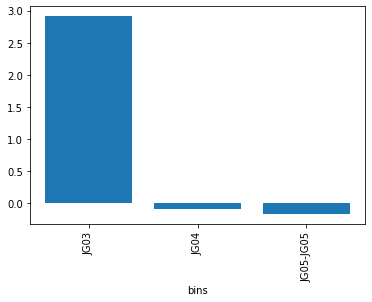

In [15]:
binning_data = {'JG03': 'JG03',
                'JG04': 'JG04',
                'JG05': 'JG05-JG05',
                'JG06': 'JG05-JG05'}
bb.transform_woe_and_pivot('job_level', binning_data=binning_data)

flag                                  0    1  TOTAL   BADRATE  DIST_BAD  \
job_duration_in_current_job_level                                         
(-1.0, 0.0]                         224    1    225  0.995556  0.014480   
(0.0, 0.5]                         1838   50   1888  0.973517  0.118811   
(0.5, 1.0]                         1590   34   1624  0.979064  0.102780   
(1.0, 1.17]                        1377  232   1609  0.855811  0.089011   
(1.17, 1.42]                       1727  322   2049  0.842850  0.111635   
(1.42, 1.58]                       1837  296   2133  0.861228  0.118746   
(1.58, 1.75]                       1563  309   1872  0.834936  0.101034   
(1.75, 1.83]                       1400  249   1649  0.848999  0.090498   
(1.83, 1.92]                       1403  220   1623  0.864449  0.090692   
(1.92, 2.5]                        1185  163   1348  0.879080  0.076600   
(2.5, inf]                         1326  258   1584  0.837121  0.085714   

flag                               DIST_GOOD       WOE            IV  
job_duration_in_current_job_level                                     
(-1.0, 0.0]                         0.000469  3.430742  4.806824e-02  
(0.0, 0.5]                          0.023430  1.623506  1.548507e-01  
(0.5, 1.0]                          0.015933  1.864224  1.619024e-01  
(1.0, 1.17]                         0.108716 -0.199979  3.940601e-03  
(1.17, 1.42]                        0.150890 -0.301315  1.182810e-02  
(1.42, 1.58]                        0.138707 -0.155375  3.101390e-03  
(1.58, 1.75]                        0.144799 -0.359883  1.575003e-02  
(1.75, 1.83]                        0.116682 -0.254130  6.654277e-03  
(1.83, 1.92]                        0.103093 -0.128164  1.589377e-03  
(1.92, 2.5]                         0.076382  0.002843  6.183988e-07  
(2.5, inf]                          0.120900 -0.343942  1.210175e-02

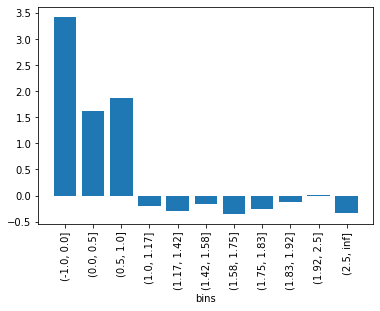

In [16]:
bb.transform_woe_and_pivot('job_duration_in_current_job_level', auto_binning=True)

flag              0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
person_level                                                                
PG01           1571     9   1580  0.994304  0.101551   0.004217  3.181339   
PG02             28     3     31  0.903226  0.001810   0.001406  0.252688   
PG03          12735  1926  14661  0.868631  0.823206   0.902530 -0.091996   
PG04            545   100    645  0.844961  0.035229   0.046860 -0.285289   
PG05            261    35    296  0.881757  0.016871   0.016401  0.028268   
PG06            311    56    367  0.847411  0.020103   0.026242 -0.266463   
PG07             17     4     21  0.809524  0.001099   0.001874 -0.533986   
PG08              2     1      3  0.666667  0.000129   0.000469 -1.287757   

flag                IV  
person_level            
PG01          0.309652  
PG02          0.000102  
PG03          0.007297  
PG04          0.003318  
PG05          0.000013  
PG06          0.001636  
PG07          0.000414  
PG08          0.000437

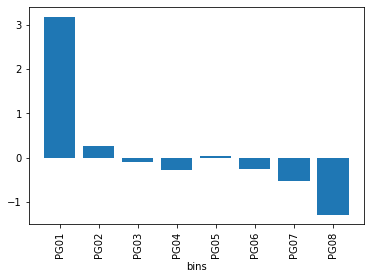

In [17]:
bb.transform_woe_and_pivot('person_level', auto_binning=True)

flag                                     0    1  TOTAL   BADRATE  DIST_BAD  \
job_duration_in_current_person_level                                         
(-1.0, 0.0]                            318    8    326  0.975460  0.020556   
(0.0, 0.5]                            1908   56   1964  0.971487  0.123335   
(0.5, 0.92]                            975   17    992  0.982863  0.063025   
(0.92, 1.17]                          2036  251   2287  0.890249  0.131610   
(1.17, 1.42]                          1726  322   2048  0.842773  0.111571   
(1.42, 1.5]                           1072  182   1254  0.854864  0.069295   
(1.5, 1.67]                           1494  243   1737  0.860104  0.096574   
(1.67, 1.83]                          2259  433   2692  0.839153  0.146025   
(1.83, 1.92]                          1404  220   1624  0.864532  0.090756   
(1.92, 2.25]                           821  128    949  0.865121  0.053070   
(2.25, inf]                           1457  274   1731  0.841710  0.094182   

flag                                  DIST_GOOD       WOE        IV  
job_duration_in_current_person_level                                 
(-1.0, 0.0]                            0.003749  1.701705  0.028601  
(0.0, 0.5]                             0.026242  1.547555  0.150258  
(0.5, 0.92]                            0.007966  2.068320  0.113880  
(0.92, 1.17]                           0.117619  0.112385  0.001572  
(1.17, 1.42]                           0.150890 -0.301894  0.011870  
(1.42, 1.5]                            0.085286 -0.207630  0.003320  
(1.5, 1.67]                            0.113871 -0.164754  0.002850  
(1.67, 1.83]                           0.202905 -0.328965  0.018712  
(1.83, 1.92]                           0.103093 -0.127451  0.001572  
(1.92, 2.25]                           0.059981 -0.122412  0.000846  
(2.25, inf]                            0.128397 -0.309898  0.010603

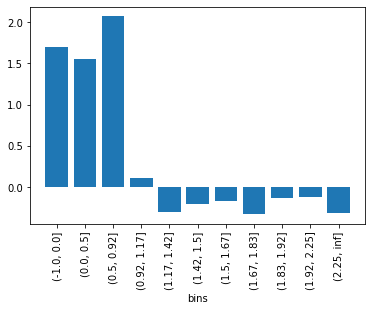

In [18]:
bb.transform_woe_and_pivot('job_duration_in_current_person_level', auto_binning=True)

flag                               0    1  TOTAL   BADRATE  DIST_BAD  \
job_duration_in_current_branch                                         
(-1.0, 0.0]                      590   56    646  0.913313  0.038138   
(0.0, 0.25]                     1277  102   1379  0.926033  0.082547   
(0.25, 0.5]                     5361  663   6024  0.889940  0.346542   
(0.5, 0.83]                      882   33    915  0.963934  0.057014   
(0.83, 1.25]                    1567  273   1840  0.851630  0.101293   
(1.25, 1.5]                     2995  592   3587  0.834960  0.193601   
(1.5, 2.42]                     1369  214   1583  0.864814  0.088494   
(2.42, inf]                     1429  201   1630  0.876687  0.092372   

flag                            DIST_GOOD       WOE        IV  
job_duration_in_current_branch                                 
(-1.0, 0.0]                      0.026242  0.373866  0.004448  
(0.0, 0.25]                      0.047798  0.546392  0.018987  
(0.25, 0.5]                      0.310684  0.109226  0.003917  
(0.5, 0.83]                      0.015464  1.304780  0.054213  
(0.83, 1.25]                     0.127929 -0.233458  0.006218  
(1.25, 1.5]                      0.277413 -0.359712  0.030148  
(1.5, 2.42]                      0.100281 -0.125045  0.001474  
(2.42, inf]                      0.094189 -0.019479  0.000035

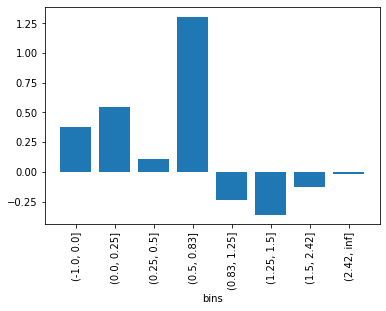

In [19]:
bb.transform_woe_and_pivot('job_duration_in_current_branch', auto_binning=True)

flag              0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
Employee_type                                                               
RM_type_A      7575  1256   8831  0.857774  0.489657   0.588566 -0.183983   
RM_type_B      7363   804   8167  0.901555  0.475953   0.376757  0.233719   
RM_type_C       532    74    606  0.877888  0.034389   0.034677 -0.008326   

flag                 IV  
Employee_type            
RM_type_A      0.018198  
RM_type_B      0.023184  
RM_type_C      0.000002

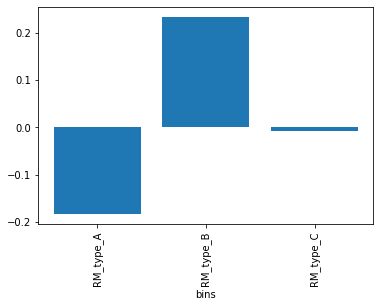

In [20]:
binning_data = {'RM_type_A': 'RM_type_A',
                'RM_type_C': 'RM_type_C',
                'RM_type_B': 'RM_type_B',
                '-99': 'RM_type_A'}
bb.transform_woe_and_pivot('Employee_type', binning_data=binning_data)

flag                   0       1    TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
Employee_status                                                            
Contract          1657.0     0.0   1657.0  1.000000  0.107111        0.0   
Permanent        13813.0  2134.0  15947.0  0.866182  0.892889        1.0   

flag                  WOE        IV  
Employee_status                      
Contract              inf       inf  
Permanent       -0.113292  0.012135

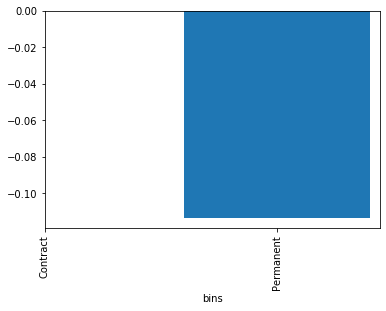

In [21]:
bb.transform_woe_and_pivot('Employee_status', auto_binning=True)

flag        0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE        IV
gender                                                                       
Female   3984   578   4562  0.873301  0.257531   0.270853 -0.050437  0.000672
Male    11486  1556  13042  0.880693  0.742469   0.729147  0.018106  0.000241

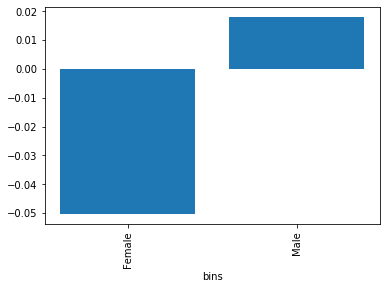

In [22]:
bb.transform_woe_and_pivot('gender', auto_binning=True)

flag             0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
age                                                                       
(-inf, 28.0]  1691  103   1794  0.942586  0.109308   0.048266  0.817442   
(28.0, 30.0]  3332  365   3697  0.901271  0.215385   0.171040  0.230526   
(30.0, 31.0]  2151  289   2440  0.881557  0.139043   0.135426  0.026357   
(31.0, 34.0]  5127  813   5940  0.863131  0.331416   0.380975 -0.139360   
(34.0, 37.0]  1869  323   2192  0.852646  0.120814   0.151359 -0.225398   
(37.0, inf]   1300  241   1541  0.843608  0.084034   0.112933 -0.295582   

flag                IV  
age                     
(-inf, 28.0]  0.049898  
(28.0, 30.0]  0.010223  
(30.0, 31.0]  0.000095  
(31.0, 34.0]  0.006907  
(34.0, 37.0]  0.006885  
(37.0, inf]   0.008542

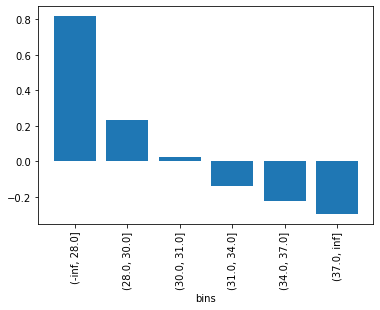

In [23]:
bb.transform_woe_and_pivot('age', [-np.inf, 28, 30, 31, 34, 37, np.inf])

flag                            0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
marital_status_maried(Y/N)                                                      
N                            4727   395   5122  0.922882  0.305559   0.185098   
Y                           10743  1739  12482  0.860679  0.694441   0.814902   

flag                             WOE        IV  
marital_status_maried(Y/N)                      
N                           0.501256  0.060382  
Y                          -0.159960  0.019269

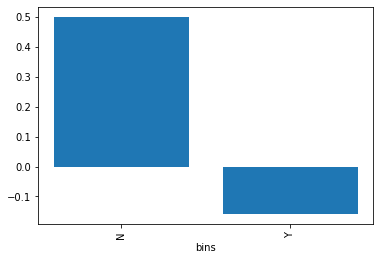

In [24]:
bb.transform_woe_and_pivot('marital_status_maried(Y/N)', auto_binning=True)

flag                      0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
number_of_dependences                                                    
(-1.0, 0.0]            7721  809   8530  0.905158  0.499095   0.379100   
(0.0, 1.0]             4810  813   5623  0.855415  0.310924   0.380975   
(1.0, 2.0]             2525  427   2952  0.855352  0.163219   0.200094   
(2.0, inf]              414   85    499  0.829659  0.026761   0.039831   

flag                        WOE        IV  
number_of_dependences                      
(-1.0, 0.0]            0.274996  0.032998  
(0.0, 1.0]            -0.203183  0.014233  
(1.0, 2.0]            -0.203692  0.007511  
(2.0, inf]            -0.397690  0.005198

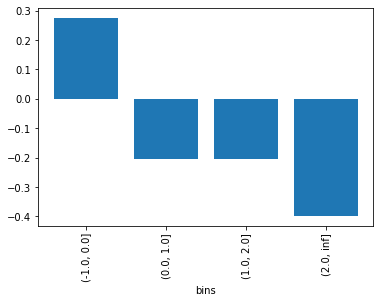

In [25]:
bb.transform_woe_and_pivot('number_of_dependences', auto_binning=True)

flag                              0     1  TOTAL   BADRATE  DIST_BAD  \
number_of_dependences (male)                                           
(-1.0, 0.0]                   10726  1299  12025  0.891975  0.693342   
(0.0, 1.0]                     3910   698   4608  0.848524  0.252747   
(1.0, inf]                      834   137    971  0.858908  0.053911   

flag                          DIST_GOOD       WOE        IV  
number_of_dependences (male)                                 
(-1.0, 0.0]                    0.608716  0.130171  0.011016  
(0.0, 1.0]                     0.327085 -0.257831  0.019167  
(1.0, inf]                     0.064199 -0.174652  0.001797

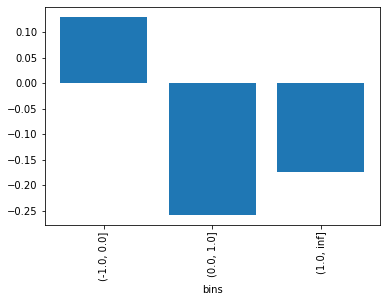

In [26]:
bb.transform_woe_and_pivot('number_of_dependences (male)', auto_binning=True)

flag                                0     1  TOTAL   BADRATE  DIST_BAD  \
number_of_dependences (female)                                           
(-1.0, 0.0]                     10850  1354  12204  0.889053  0.701357   
(0.0, 1.0]                       3832   633   4465  0.858231  0.247705   
(1.0, inf]                        788   147    935  0.842781  0.050937   

flag                            DIST_GOOD       WOE        IV  
number_of_dependences (female)                                 
(-1.0, 0.0]                      0.634489  0.100197  0.006700  
(0.0, 1.0]                       0.296626 -0.180233  0.008817  
(1.0, inf]                       0.068885 -0.301839  0.005417

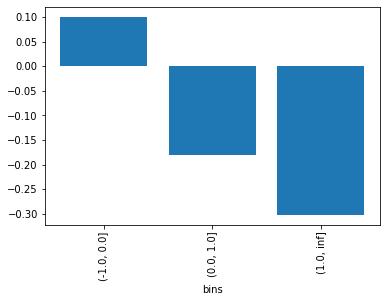

In [27]:
bb.transform_woe_and_pivot('number_of_dependences (female)', auto_binning=True)

flag                   0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
Education_level                                                        
-99                 2445   445   2890  0.846021  0.158048   0.208529   
level_0 - level_1    140    28    168  0.833333  0.009050   0.013121   
level_2 - level_3   1996   263   2259  0.883577  0.129024   0.123243   
level_4 - level_5  10889  1398  12287  0.886221  0.703878   0.655108   

flag                    WOE        IV  
Education_level                        
-99               -0.277178  0.013992  
level_0 - level_1 -0.371467  0.001512  
level_2 - level_3  0.045842  0.000265  
level_4 - level_5  0.071806  0.003502

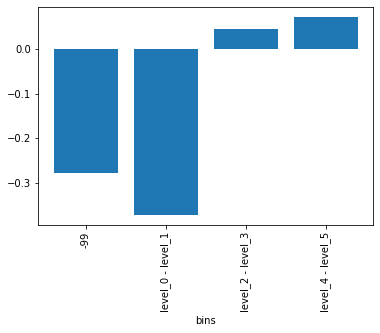

In [28]:
binning_data= {'-99': '-99',
  'level_0': 'level_0 - level_1',
  'level_1': 'level_0 - level_1',
  'level_2': 'level_2 - level_3',
  'level_3': 'level_2 - level_3',
  'level_4': 'level_4 - level_5',
  'level_5': 'level_4 - level_5'}

bb.transform_woe_and_pivot('Education_level', binning_data=binning_data)

flag                0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
GPA                                                                          
(-100.0, -99.0]  2366  433   2799  0.845302  0.152941   0.202905 -0.282686   
(-99.0, 0.0]     2657  400   3057  0.869153  0.171752   0.187441 -0.087416   
(0.0, 2.89]      1053  162   1215  0.866667  0.068067   0.075914 -0.109102   
(2.89, 3.01]     1540  207   1747  0.881511  0.099548   0.097001  0.025914   
(3.01, 3.11]     1659  193   1852  0.895788  0.107240   0.090440  0.170376   
(3.11, 3.2]      1481  200   1681  0.881023  0.095734   0.093721  0.021251   
(3.2, 3.31]      1642  184   1826  0.899233  0.106141   0.086223  0.207830   
(3.31, 3.46]     1516  186   1702  0.890717  0.097996   0.087160  0.117179   
(3.46, inf]      1556  169   1725  0.902029  0.100582   0.079194  0.239070   

flag                   IV  
GPA                        
(-100.0, -99.0]  0.014124  
(-99.0, 0.0]     0.001372  
(0.0, 2.89]      0.000856  
(2.89, 3.01]     0.000066  
(3.01, 3.11]     0.002862  
(3.11, 3.2]      0.000043  
(3.2, 3.31]      0.004140  
(3.31, 3.46]     0.001270  
(3.46, inf]      0.005113

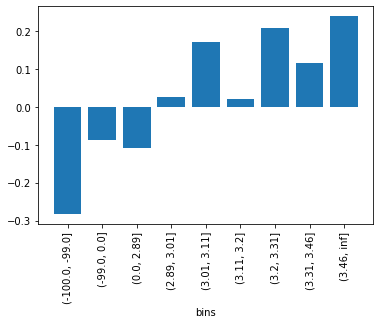

In [29]:
bb.transform_woe_and_pivot('GPA', auto_binning=True)

flag                 0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
year_graduated                                                                
(-100.0, -99.0]   2425  450   2875  0.843478  0.156755   0.210872 -0.296565   
(-99.0, 2000.0]    555   94    649  0.855162  0.035876   0.044049 -0.205231   
(2000.0, 2007.0]  1594  263   1857  0.858374  0.103038   0.123243 -0.179057   
(2007.0, 2009.0]  1756  290   2046  0.858260  0.113510   0.135895 -0.179992   
(2009.0, 2010.0]  1288  204   1492  0.863271  0.083258   0.095595 -0.138179   
(2010.0, 2011.0]  1578  218   1796  0.878619  0.102004   0.102156 -0.001486   
(2011.0, 2012.0]  1625  180   1805  0.900277  0.105042   0.084349  0.219402   
(2012.0, 2013.0]  1834  209   2043  0.897699  0.118552   0.097938  0.191016   
(2013.0, 2014.0]  1484  164   1648  0.900485  0.095928   0.076851  0.221725   
(2014.0, inf]     1331   62   1393  0.955492  0.086037   0.029053  1.085647   

flag                        IV  
year_graduated                  
(-100.0, -99.0]   1.604910e-02  
(-99.0, 2000.0]   1.677323e-03  
(2000.0, 2007.0]  3.617768e-03  
(2007.0, 2009.0]  4.029116e-03  
(2009.0, 2010.0]  1.704738e-03  
(2010.0, 2011.0]  2.254342e-07  
(2011.0, 2012.0]  4.540162e-03  
(2012.0, 2013.0]  3.937581e-03  
(2013.0, 2014.0]  4.229772e-03  
(2014.0, inf]     6.186458e-02

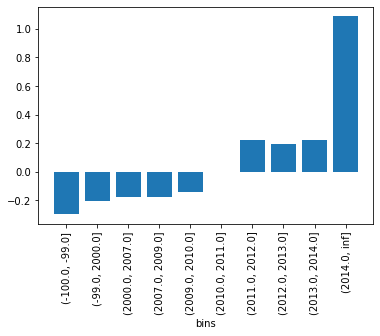

In [30]:
bb.transform_woe_and_pivot('year_graduated', auto_binning=True)

flag                                   0      1   TOTAL   BADRATE  DIST_BAD  \
job_duration_as_permanent_worker                                              
(-100.0, -99.0]                   1657.0    0.0  1657.0  1.000000  0.107111   
(-99.0, 1.0]                      2477.0  129.0  2606.0  0.950499  0.160116   
(1.0, 2.0]                        1157.0  198.0  1355.0  0.853875  0.074790   
(2.0, 3.0]                        1686.0  335.0  2021.0  0.834240  0.108985   
(3.0, 4.0]                        2920.0  499.0  3419.0  0.854051  0.188752   
(4.0, 5.0]                        1965.0  315.0  2280.0  0.861842  0.127020   
(5.0, 6.0]                        2014.0  366.0  2380.0  0.846218  0.130187   
(6.0, 7.0]                         558.0  104.0   662.0  0.842900  0.036070   
(7.0, inf]                        1036.0  188.0  1224.0  0.846405  0.066968   

flag                              DIST_GOOD       WOE        IV  
job_duration_as_permanent_worker                                 
(-100.0, -99.0]                    0.000000       inf       inf  
(-99.0, 1.0]                       0.060450  0.974087  0.097084  
(1.0, 2.0]                         0.092784 -0.215586  0.003879  
(2.0, 3.0]                         0.156982 -0.364921  0.017515  
(3.0, 4.0]                         0.233833 -0.214172  0.009655  
(4.0, 5.0]                         0.147610 -0.150230  0.003093  
(5.0, 6.0]                         0.171509 -0.275660  0.011391  
(6.0, 7.0]                         0.048735 -0.300936  0.003811  
(7.0, inf]                         0.088097 -0.274224  0.005794

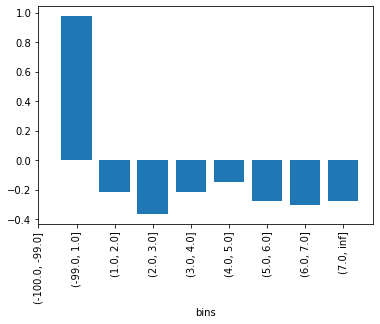

In [31]:
bb.transform_woe_and_pivot('job_duration_as_permanent_worker', auto_binning=True)

flag                           0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
job_duration_from_training                                                    
(0.0, 1.0]                  4120  129   4249  0.969640  0.266322   0.060450   
(1.0, 2.0]                  1171  198   1369  0.855369  0.075695   0.092784   
(2.0, 3.0]                  1686  335   2021  0.834240  0.108985   0.156982   
(3.0, 4.0]                  2920  499   3419  0.854051  0.188752   0.233833   
(4.0, 5.0]                  1965  315   2280  0.861842  0.127020   0.147610   
(5.0, 6.0]                  2014  366   2380  0.846218  0.130187   0.171509   
(6.0, 7.0]                   558  104    662  0.842900  0.036070   0.048735   
(7.0, inf]                  1036  188   1224  0.846405  0.066968   0.088097   

flag                             WOE        IV  
job_duration_from_training                      
(0.0, 1.0]                  1.482892  0.305286  
(1.0, 2.0]                 -0.203558  0.003479  
(2.0, 3.0]                 -0.364921  0.017515  
(3.0, 4.0]                 -0.214172  0.009655  
(4.0, 5.0]                 -0.150230  0.003093  
(5.0, 6.0]                 -0.275660  0.011391  
(6.0, 7.0]                 -0.300936  0.003811  
(7.0, inf]                 -0.274224  0.005794

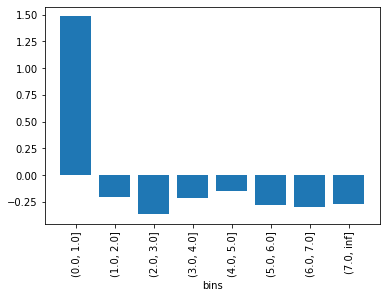

In [32]:
bb.transform_woe_and_pivot('job_duration_from_training', auto_binning=True)

flag                0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
branch_rotation                                                              
(0.0, 1.0]       4034  203   4237  0.952089  0.260763   0.095127  1.008403   
(1.0, 2.0]       4526  682   5208  0.869048  0.292566   0.319588 -0.088340   
(2.0, 3.0]       3461  639   4100  0.844146  0.223723   0.299438 -0.291496   
(3.0, 4.0]       1668  310   1978  0.843276  0.107822   0.145267 -0.298096   
(4.0, 5.0]        613   89    702  0.873219  0.039625   0.041706 -0.051176   
(5.0, inf]       1168  211   1379  0.846991  0.075501   0.098875 -0.269714   

flag                   IV  
branch_rotation            
(0.0, 1.0]       0.167028  
(1.0, 2.0]       0.002387  
(2.0, 3.0]       0.022070  
(3.0, 4.0]       0.011162  
(4.0, 5.0]       0.000106  
(5.0, inf]       0.006304

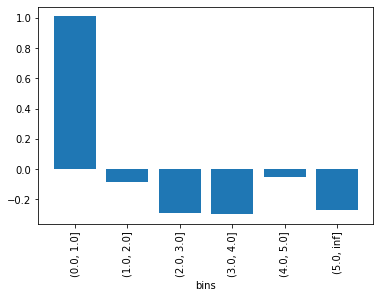

In [33]:
bb.transform_woe_and_pivot('branch_rotation', auto_binning=True)

flag             0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
job_rotation                                                              
(0.0, 1.0]    3193   21   3214  0.993466  0.206399   0.009841  3.043289   
(1.0, 2.0]    5153  822   5975  0.862427  0.333096   0.385192 -0.145311   
(2.0, 3.0]    3733  670   4403  0.847831  0.241306   0.313964 -0.263215   
(3.0, 4.0]    1753  320   2073  0.845634  0.113316   0.149953 -0.280142   
(4.0, 5.0]     611  100    711  0.859353  0.039496   0.046860 -0.170978   
(5.0, inf]    1027  201   1228  0.836319  0.066387   0.094189 -0.349812   

flag                IV  
job_rotation            
(0.0, 1.0]    0.598185  
(1.0, 2.0]    0.007570  
(2.0, 3.0]    0.019125  
(3.0, 4.0]    0.010264  
(4.0, 5.0]    0.001259  
(5.0, inf]    0.009726

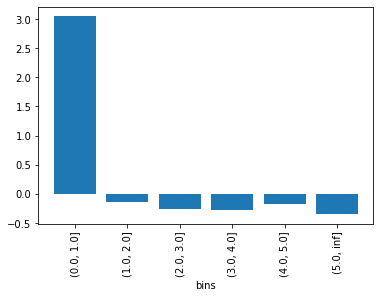

In [34]:
bb.transform_woe_and_pivot('job_rotation', auto_binning=True)

flag                         0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
assign_of_otherposition                                                      
(-1.0, 0.0]              11773  1545  13318  0.883992  0.761021   0.723993   
(0.0, 1.0]                1439   213   1652  0.871065  0.093019   0.099813   
(1.0, 3.0]                1094   186   1280  0.854688  0.070718   0.087160   
(3.0, inf]                1164   190   1354  0.859675  0.075242   0.089035   

flag                          WOE        IV  
assign_of_otherposition                      
(-1.0, 0.0]              0.049880  0.001847  
(0.0, 1.0]              -0.070493  0.000479  
(1.0, 3.0]              -0.209055  0.003437  
(3.0, inf]              -0.168311  0.002321

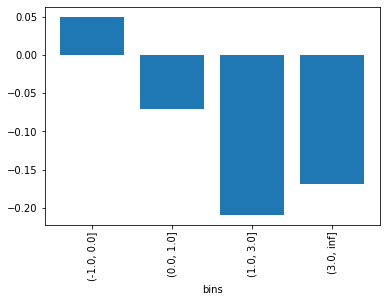

In [35]:
bb.transform_woe_and_pivot('assign_of_otherposition', auto_binning=True)

flag             0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
annual leave                                                              
(-1.0, 0.0]   5554  433   5987  0.927677  0.359017   0.202905  0.570631   
(0.0, 2.0]    2262  429   2691  0.840580  0.146218   0.201031 -0.318357   
(2.0, 3.0]    2722  464   3186  0.854363  0.175953   0.217432 -0.211667   
(3.0, 4.0]    1187  187   1374  0.863901  0.076729   0.087629 -0.132829   
(4.0, 5.0]    1418  233   1651  0.858873  0.091661   0.109185 -0.174940   
(5.0, 6.0]     848  134    982  0.863544  0.054816   0.062793 -0.135864   
(6.0, inf]    1479  254   1733  0.853433  0.095604   0.119025 -0.219117   

flag                IV  
annual leave            
(-1.0, 0.0]   0.089082  
(0.0, 2.0]    0.017450  
(2.0, 3.0]    0.008780  
(3.0, 4.0]    0.001448  
(4.0, 5.0]    0.003066  
(5.0, 6.0]    0.001084  
(6.0, inf]    0.005132

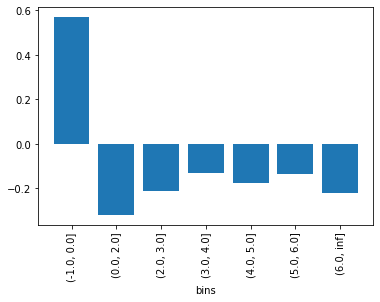

In [36]:
bb.transform_woe_and_pivot('annual leave', auto_binning=True)

flag             0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
sick_leaves                                                                
(-1.0, 0.0]  11164  1389  12553  0.889349  0.721655   0.650890  0.103206   
(0.0, 1.0]    1777   283   2060  0.862621  0.114867   0.132615 -0.143670   
(1.0, 3.0]    1502   263   1765  0.850992  0.097091   0.123243 -0.238506   
(3.0, inf]    1027   199   1226  0.837684  0.066387   0.093252 -0.339812   

flag               IV  
sick_leaves            
(-1.0, 0.0]  0.007303  
(0.0, 1.0]   0.002550  
(1.0, 3.0]   0.006237  
(3.0, inf]   0.009129

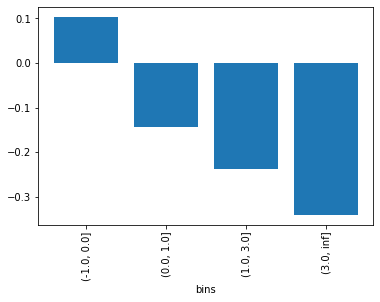

In [37]:
bb.transform_woe_and_pivot('sick_leaves', auto_binning=True)

flag                  0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
Avg_achievement_%                                                              
(-100.0, -99.0]    4801  258   5059  0.949002  0.310343   0.120900  0.942715   
(-99.0, 13.826]     194   28    222  0.873874  0.012540   0.013121 -0.045251   
(13.826, 45.055]   1505  256   1761  0.854628  0.097285   0.119963 -0.209534   
(45.055, 54.785]   1485  275   1760  0.843750  0.095992   0.128866 -0.294506   
(54.785, 62.932]   1508  252   1760  0.856818  0.097479   0.118088 -0.191794   
(62.932, 70.55]    1499  262   1761  0.851221  0.096897   0.122774 -0.236696   
(70.55, 79.403]    1502  258   1760  0.853409  0.097091   0.120900 -0.219311   
(79.403, 92.625]   1484  276   1760  0.843182  0.095928   0.129335 -0.298809   
(92.625, inf]      1492  269   1761  0.847246  0.096445   0.126054 -0.267743   

flag                     IV  
Avg_achievement_%            
(-100.0, -99.0]    0.178591  
(-99.0, 13.826]    0.000026  
(13.826, 45.055]   0.004752  
(45.055, 54.785]   0.009681  
(54.785, 62.932]   0.003953  
(62.932, 70.55]    0.006125  
(70.55, 79.403]    0.005221  
(79.403, 92.625]   0.009982  
(92.625, inf]      0.007928

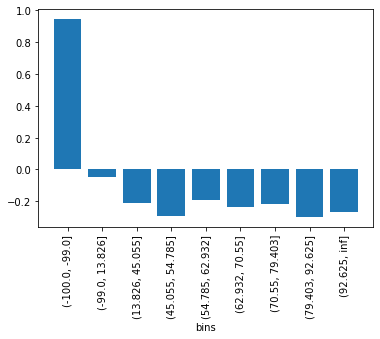

In [38]:
bb.transform_woe_and_pivot('Avg_achievement_%', auto_binning=True)

flag                   0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
Last_achievement_%                                                              
(-100.0, -99.0]     4811  258   5069  0.949102  0.310989   0.120900  0.944796   
(-99.0, 13.939]      182   30    212  0.858491  0.011765   0.014058 -0.178095   
(13.939, 48.57]     1498  264   1762  0.850170  0.096833   0.123711 -0.244967   
(48.57, 59.18]      1500  260   1760  0.852273  0.096962   0.121837 -0.228366   
(59.18, 67.85]      1483  279   1762  0.841657  0.095863   0.130740 -0.310294   
(67.85, 76.29]      1492  268   1760  0.847727  0.096445   0.125586 -0.264019   
(76.29, 85.628]     1500  258   1758  0.853242  0.096962   0.120900 -0.220644   
(85.628, 98.91]     1513  248   1761  0.859171  0.097802   0.116214 -0.172484   
(98.91, inf]        1491  269   1760  0.847159  0.096380   0.126054 -0.268414   

flag                      IV  
Last_achievement_%            
(-100.0, -99.0]     0.179596  
(-99.0, 13.939]     0.000408  
(13.939, 48.57]     0.006584  
(48.57, 59.18]      0.005681  
(59.18, 67.85]      0.010822  
(67.85, 76.29]      0.007694  
(76.29, 85.628]     0.005282  
(85.628, 98.91]     0.003176  
(98.91, inf]        0.007965

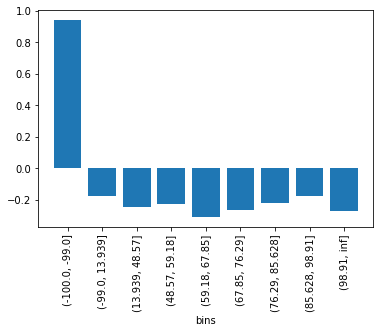

In [39]:
bb.transform_woe_and_pivot('Last_achievement_%', auto_binning=True)

flag                                      0     1  TOTAL   BADRATE  DIST_BAD  \
Achievement_above_100%_during3quartal                                          
(-100.0, -99.0]                        4811   258   5069  0.949102  0.310989   
(-99.0, 0.0]                           7246  1279   8525  0.849971  0.468390   
(0.0, 1.0]                             1055   165   1220  0.864754  0.068197   
(1.0, 3.0]                             2358   432   2790  0.845161  0.152424   

flag                                   DIST_GOOD       WOE        IV  
Achievement_above_100%_during3quartal                                 
(-100.0, -99.0]                         0.120900  0.944796  0.179596  
(-99.0, 0.0]                            0.599344 -0.246533  0.032284  
(0.0, 1.0]                              0.077320 -0.125554  0.001145  
(1.0, 3.0]                              0.202437 -0.283761  0.014192

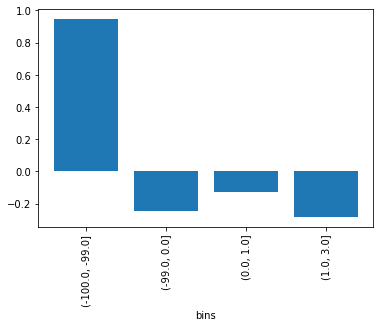

In [40]:
bb.transform_woe_and_pivot('Achievement_above_100%_during3quartal', auto_binning=True)

flag                       0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
achievement_target_1                                                       
Tidak diberikan target  5235   331   5566  0.940532  0.338397   0.155108   
achiev_100%-150%        2070   344   2414  0.857498  0.133807   0.161200   
achiev_50%-100%         6204  1114   7318  0.847773  0.401034   0.522024   
achiev_< 50%            1512   271   1783  0.848009  0.097738   0.126992   
achiev_> 1.5             449    74    523  0.858509  0.029024   0.034677   

flag                         WOE        IV  
achievement_target_1                        
Tidak diberikan target  0.780099  0.142984  
achiev_100%-150%       -0.186242  0.005102  
achiev_50%-100%        -0.263667  0.031901  
achiev_< 50%           -0.261835  0.007660  
achiev_> 1.5           -0.177947  0.001006

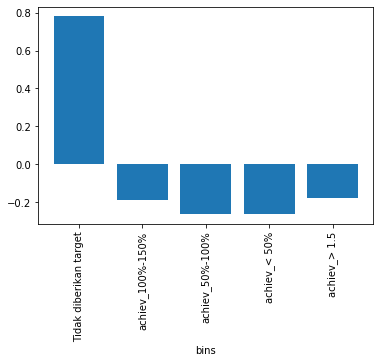

In [41]:
binning_data = {'achiev_50%-100%': 'achiev_50%-100%',
            'achiev_100%-150%': 'achiev_100%-150%',
            'achiev_< 50%': 'achiev_< 50%',
            'achiev_> 1.5': 'achiev_> 1.5',
            '-99': 'Tidak diberikan target',
            'Tidak diberikan target': 'Tidak diberikan target',
            'Pencapaian 50%-100%': 'achiev_50%-100%',
            'Pencapaian 100%-150%': 'achiev_100%-150%',
            'Pencapaian < 50%': 'achiev_< 50%',
            'Pencapaian > 1.5': 'achiev_> 1.5'}
bb.transform_woe_and_pivot('achievement_target_1', binning_data=binning_data)

flag                       0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
achievement_target_2                                                       
Tidak diberikan target  5228   321   5549  0.942152  0.337944   0.150422   
achiev_100%-150%         739   110    849  0.870436  0.047770   0.051546   
achiev_50%-100%         1940   338   2278  0.851624  0.125404   0.158388   
achiev_< 50%            6880  1226   8106  0.848754  0.444732   0.574508   
achiev_> 1.5             683   139    822  0.830900  0.044150   0.065136   

flag                         WOE        IV  
achievement_target_2                        
Tidak diberikan target  0.809438  0.151788  
achiev_100%-150%       -0.076087  0.000287  
achiev_50%-100%        -0.233507  0.007702  
achiev_< 50%           -0.256043  0.033228  
achiev_> 1.5           -0.388884  0.008161

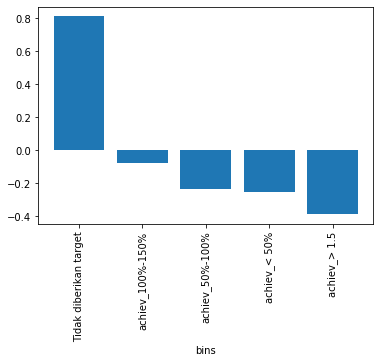

In [42]:
binning_data = {'achiev_50%-100%': 'achiev_50%-100%',
            'achiev_100%-150%': 'achiev_100%-150%',
            'achiev_< 50%': 'achiev_< 50%',
            'achiev_> 1.5': 'achiev_> 1.5',
            '-99': 'Tidak diberikan target',
            'Tidak diberikan target': 'Tidak diberikan target',
            'Pencapaian 50%-100%': 'achiev_50%-100%',
            'Pencapaian 100%-150%': 'achiev_100%-150%',
            'Pencapaian < 50%': 'achiev_< 50%',
            'Pencapaian > 1.5': 'achiev_> 1.5'}
bb.transform_woe_and_pivot('achievement_target_2', binning_data=binning_data)

flag                     0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
achievement_target_3                                                     
-99                   5110   306   5416  0.943501  0.330317   0.143393   
not_reached           2859   562   3421  0.835721  0.184809   0.263355   
reached               7501  1266   8767  0.855595  0.484874   0.593252   

flag                       WOE        IV  
achievement_target_3                      
-99                   0.834465  0.155982  
not_reached          -0.354179  0.027819  
reached              -0.201730  0.021863

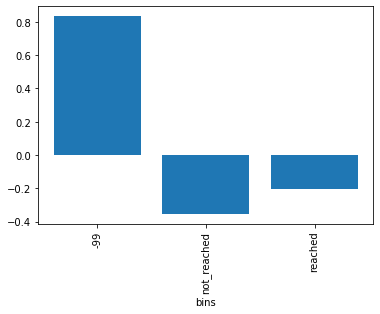

In [43]:
binning_data= {'reached': 'reached',
  'not_reached': 'not_reached',
  '-99': '-99',
  'not reached': 'not_reached'}
bb.transform_woe_and_pivot('achievement_target_3', binning_data=binning_data)

In [44]:
features_list = bb.calculate_ivs(data_train.loc[:, (data_train.columns != 'flag') & (data_train.columns != 'Employee_status')].columns.tolist())

In [45]:
features_list

[['job_rotation', 0.6461286831541827],
 ['job_duration_in_current_job_level', 0.4197874205661453],
 ['job_duration_from_training', 0.36002397097402455],
 ['job_duration_in_current_person_level', 0.3440836167548931],
 ['person_level', 0.3228700664484765],
 ['job_level', 0.29537460789815534],
 ['Achievement_above_100%_during3quartal', 0.2272171437702534],
 ['Last_achievement_%', 0.22720753250351858],
 ['Avg_achievement_%', 0.22625939931655187],
 ['branch_rotation', 0.20905889078069645],
 ['achievement_target_3', 0.20566409068402886],
 ['achievement_target_2', 0.20116673421684772],
 ['achievement_target_1', 0.18865205001934626],
 ['job_duration_as_permanent_worker', 0.15222247099114555],
 ['annual leave', 0.12604109313895787],
 ['job_duration_in_current_branch', 0.11944033003820217],
 ['year_graduated', 0.1016503706844328],
 ['age', 0.08254974620191488],
 ['marital_status_maried(Y/N)', 0.07965058329732361],
 ['number_of_dependences', 0.059939898751097655],
 ['Employee_type', 0.04138396185

In [46]:
[feature[0] for feature in features_list]

['job_rotation',
 'job_duration_in_current_job_level',
 'job_duration_from_training',
 'job_duration_in_current_person_level',
 'person_level',
 'job_level',
 'Achievement_above_100%_during3quartal',
 'Last_achievement_%',
 'Avg_achievement_%',
 'branch_rotation',
 'achievement_target_3',
 'achievement_target_2',
 'achievement_target_1',
 'job_duration_as_permanent_worker',
 'annual leave',
 'job_duration_in_current_branch',
 'year_graduated',
 'age',
 'marital_status_maried(Y/N)',
 'number_of_dependences',
 'Employee_type',
 'number_of_dependences (male)',
 'GPA',
 'sick_leaves',
 'number_of_dependences (female)',
 'Education_level',
 'assign_of_otherposition',
 'gender']

## Modelling

In [47]:
logistic = LogisticRegression(solver='lbfgs')

In [48]:
features = [
    'job_rotation',
    'job_duration_in_current_job_level',
    'job_duration_from_training',
    'job_duration_in_current_person_level',
    'Achievement_above_100%_during3quartal',
    'Last_achievement_%',
    'Avg_achievement_%',
    'branch_rotation',
    'job_duration_as_permanent_worker',
    'annual leave',
    'job_duration_in_current_branch',
    'year_graduated',
    'age',
    'number_of_dependences',
    'number_of_dependences (male)',
    'GPA',
    'sick_leaves',
    'number_of_dependences (female)',
    'assign_of_otherposition'
 ]

categorical_features = [
    'job_level', 
    'person_level', 
    'Employee_type', 
    # 'Employee_status', 
    'gender', 
    'marital_status_maried(Y/N)', 
    'Education_level', 
    'achievement_target_1', 
    'achievement_target_2', 
    'achievement_target_3'
]

In [49]:
sc = Scorecard(data_train, data_validation)
sc.load_meta_data_from_dict(bb.save_meta_data_to_dict())
sc.woe_transform(categorical_features, auto_binning=False)

In [50]:
X_train = data_train.join(sc.get_woe(data_train, categorical_features)['data_woe'], how='left', rsuffix='_WOE')[features+[i+'_WOE' for i in categorical_features]]
y_train = data_train['flag']

X_val = data_validation.join(sc.get_woe(data_validation, categorical_features)['data_woe'], how='left', rsuffix='_WOE')[features+[i+'_WOE' for i in categorical_features]]
y_val = data_validation['flag']

In [51]:
params = {'min_child_weight': 0.6715,
            'max_depth': 12,
            'num_leaves': 20,
            'min_child_samples' :24,
            'bagging_fraction' : 0.8538,
            'lambda_l1' : 0.7467,
            'lambda_l2' : 0.6911
            }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)

y_pred_proba = model_lgb.predict_proba(X_train)[:,1]
print('train_auc_roc:',roc_auc_score(y_train,y_pred_proba))

y_pred_proba = model_lgb.predict_proba(X_val)[:,1]
print('validation_auc_roc:',roc_auc_score(y_val,y_pred_proba))

[LightGBM] [Warning] lambda_l1 is set=0.7467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7467
[LightGBM] [Warning] bagging_fraction is set=0.8538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8538
[LightGBM] [Warning] lambda_l2 is set=0.6911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6911
train_auc_roc: 0.864711743683848
validation_auc_roc: 0.6497519586165083


In [52]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

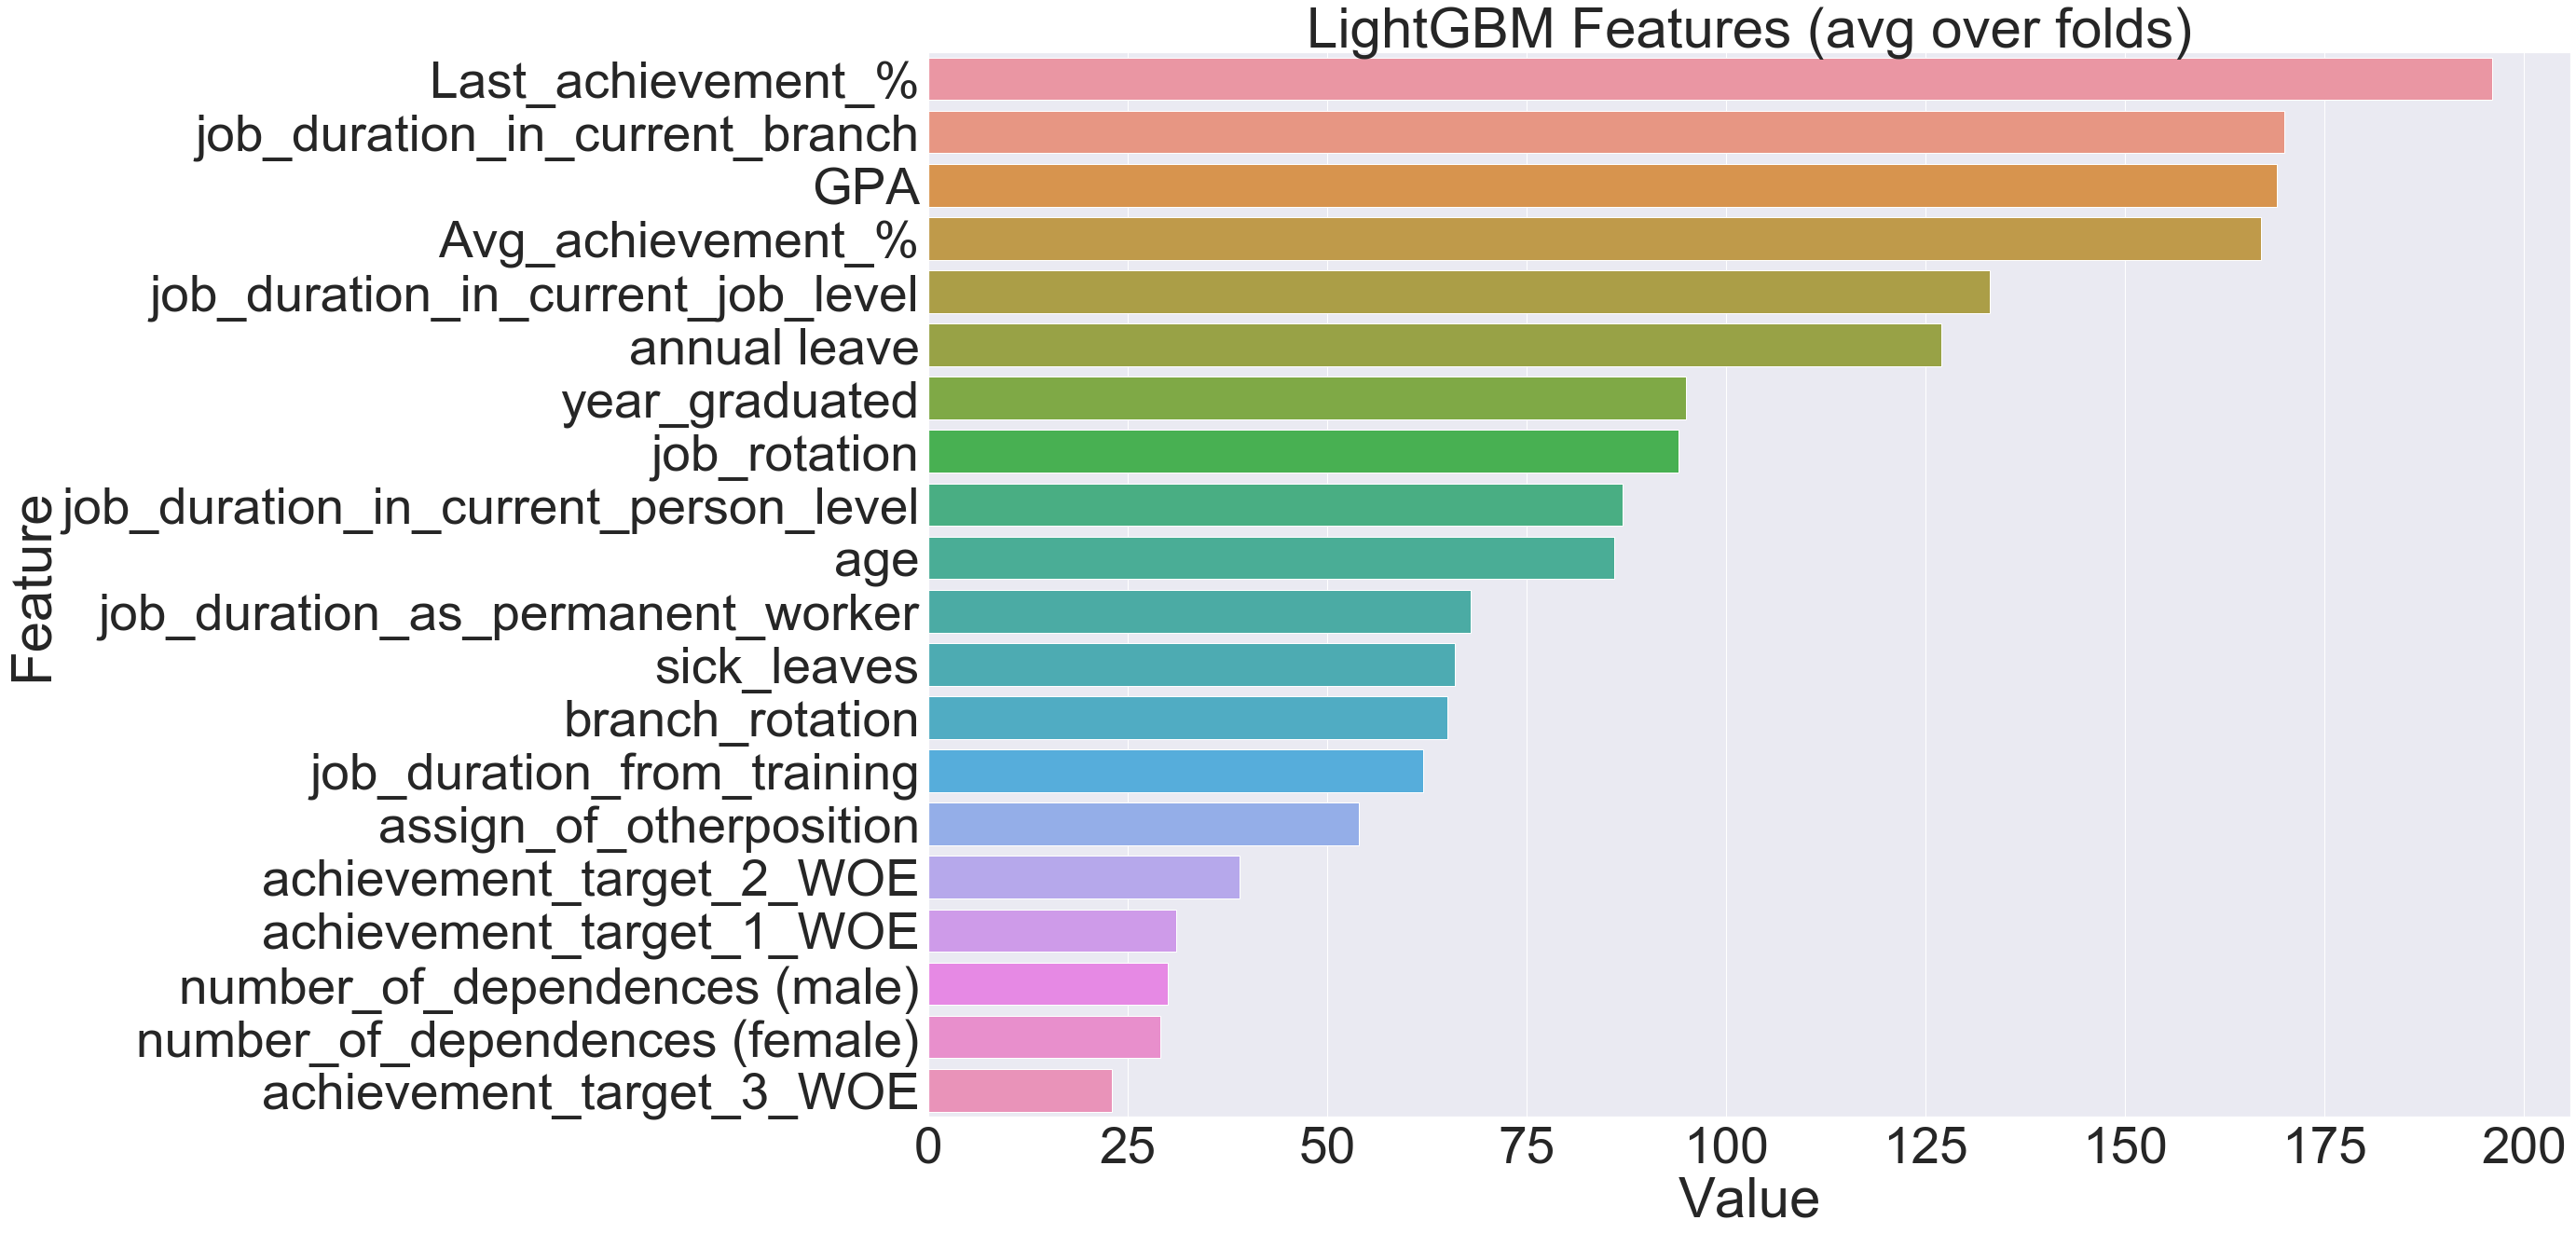

In [70]:
plotImp(model_lgb, X_train)

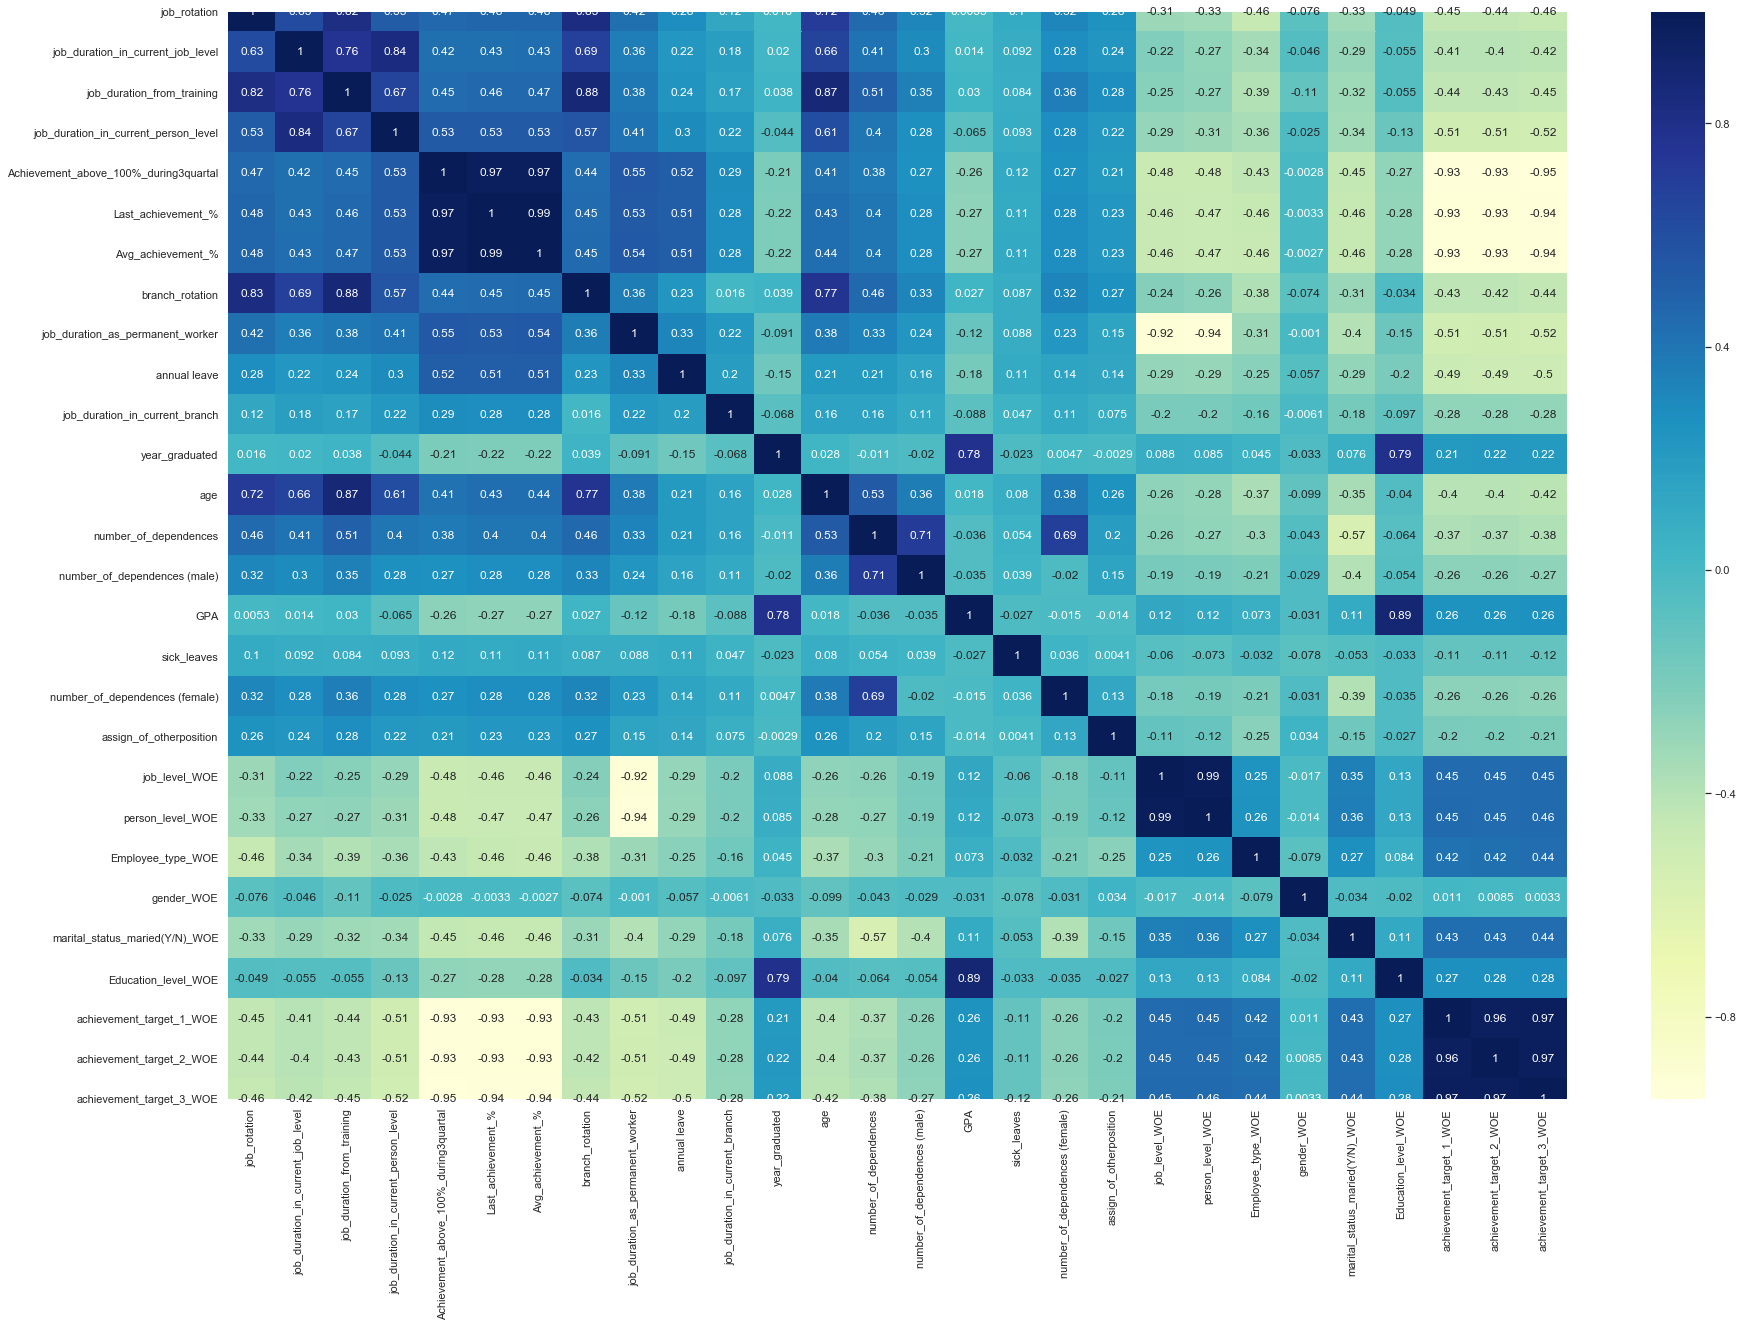

In [54]:
df = X_train
df = df.loc[:,~(df.columns.str.contains('id|flag'))]
corrMatrix = df.corr()
sns.set(font_scale = 1)
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")

## Predict

In [62]:
X_test = data_test.join(sc.get_woe(data_test, categorical_features)['data_woe'], how='left', rsuffix='_WOE')[features+[i+'_WOE' for i in categorical_features]]

y_pred_proba = model_lgb.predict_proba(X_test)[:,1]

result_test = pd.DataFrame({'Employee_status':data_test['Employee_status'], 'Best Performance':y_pred_proba})

# threshold_proba = 0.6

# result_test['Best Performance'] = result_test['predict_proba'].apply(lambda x: 1 if x > threshold_proba else 0)
# result_test['Best Performance'] = result_test.apply(lambda x: 0 if x['Employee_status']=='Contract' else x['Best Performance'], axis=1) 

In [64]:
result_test['Best Performance']

0       0.074299
1       0.126939
2       0.173529
3       0.101137
4       0.037023
          ...   
5995    0.140092
5996    0.175333
5997    0.123197
5998    0.385853
5999    0.139988
Name: Best Performance, Length: 6000, dtype: float64

In [65]:
result_test.reset_index()[['index','Best Performance']].to_csv('submission.csv', index=False)